In [20]:
import matplotlib.pyplot as plt
import pickle


In [56]:
def plothillclimb(file):
    if "pkl" not in file:
        file += ".pkl"
    if "out" not in file:
        file = "out/" + file
    with open(file,'rb') as savefile:
        save = pickle.load(savefile)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
    accs = [log['validation']['accuracy'][-1] for (key, log) in save.items() if key != "args"]
    maxacc = max(accs)
    minacc = min(accs)
    epochsteps = [log['epochsteps'][-1] for (key, log) in save.items() if key != "args"]
    print(minacc, maxacc)
    ax1.set_yscale('log')
    for (i, (uuid, log)) in enumerate(sorted([(key, log) for (key, log) in save.items() if key != "args"], key=lambda x: x[1]['validation']['accuracy'][-1], reverse=True)):
        if len(log['epochsteps']) > 5 and log['epochsteps'][0] == log['epochsteps'][5]:
            for i in range(5):
                log['epochsteps'][i] -= 1
            for i in range(190):
                log['trainsteps'][i] -= 1
        alpha = ((log['validation']['accuracy'][-1]-minacc)/(maxacc-minacc))**5
        if i < 10 and log['epochsteps'][-1] > max(epochsteps)*0.9:
            if type(log["ghistory"][-1][-1]) is tuple:
                label = str(log["ghistory"][-1])+" - "+str(log['validation']['accuracy'][-1])[:6]
            else:
                label = str(log["ghistory"][-6:])+" - "+str(log['validation']['accuracy'][-1])[:6]
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
            label = label.replace('(0, 4)', '$C_{16}$')
        else:
            label = None
        if alpha > 0.0:
            ax1.plot(log['trainsteps'], log['train']['batchloss'], alpha=alpha, linewidth = alpha)
            ax2.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, linewidth = alpha)
            ax3.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, label=label)
    ax3.set_ylim(0.8*maxacc, 1.05*maxacc)
    ax3.legend(loc='upper left')
    ax1.set_title('Training loss')
    ax2.set_title('Validation accuracy')
    ax3.set_title('Validation accuracy (zoomed in)')
    ax1.set_xlabel('Iterations')
    ax2.set_xlabel('Iterations')
    ax3.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax3.set_ylabel('Accuracy')

    plt.savefig(file[:-2]+'ng')


0.1525000035762787 0.8812500238418579


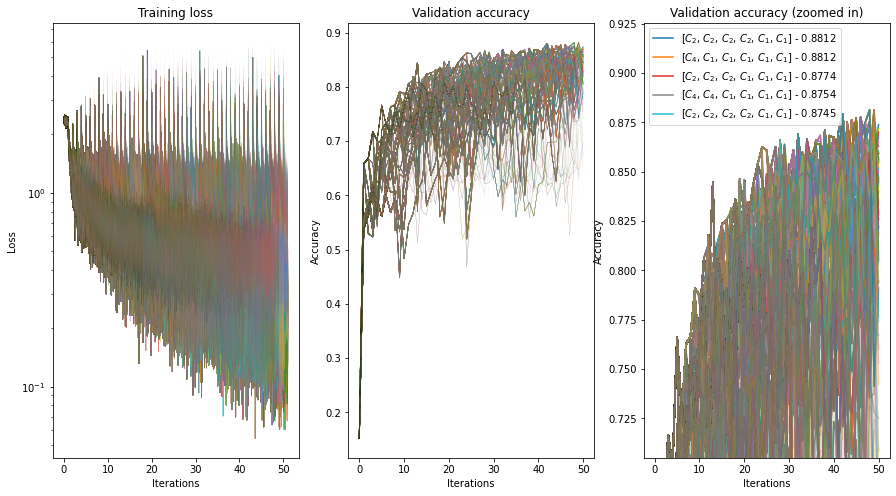

In [22]:
plothillclimb('out/logshc_2022-06-27_17:30:06.pkl')


0.13083334267139435 0.8975000381469727


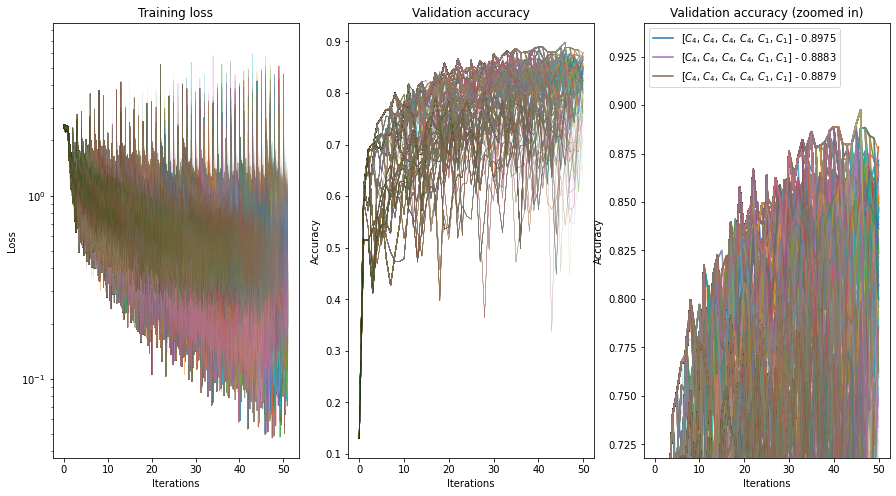

In [12]:
plothillclimb('out/logshc_2022-06-27_17:31:39.pkl')


0.7262499928474426 0.8741666674613953


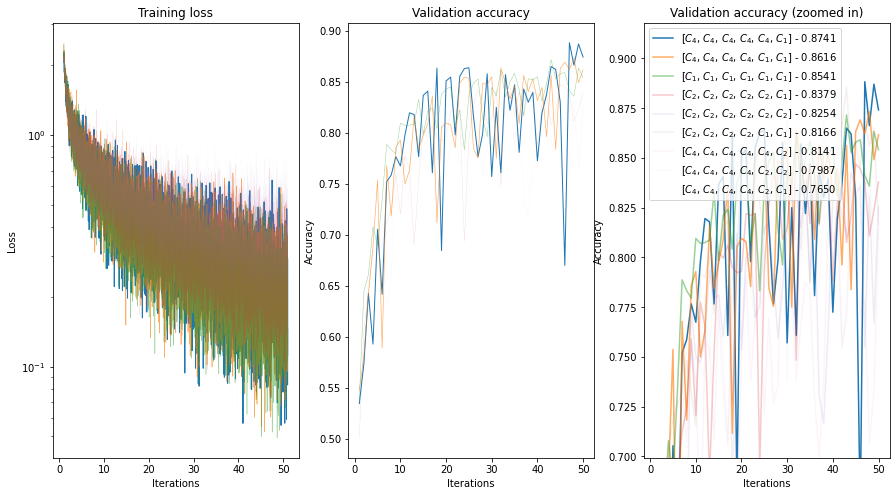

In [17]:
plothillclimb('out/logshc_2022-06-28_10:16:20.pkl')


0.15958333015441895 0.8695833683013916


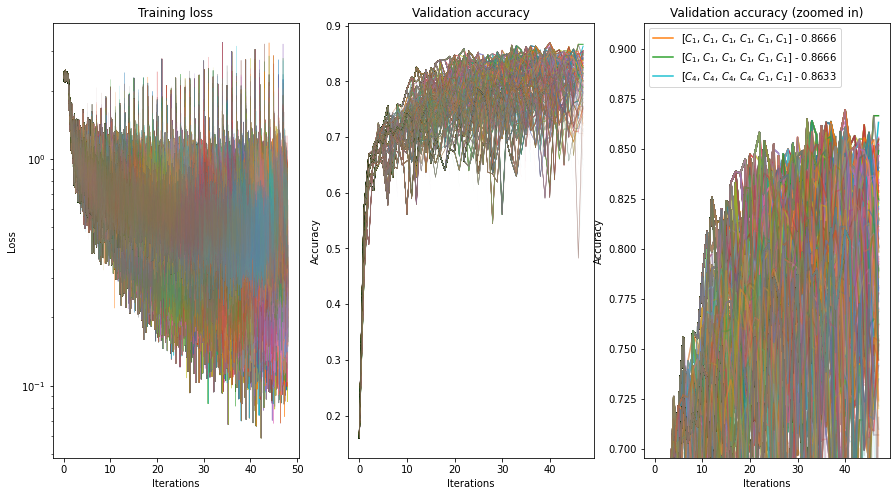

In [39]:
plothillclimb('out/aniti/logshc_2022-06-29_10:53:12.pkl')


0.7345833778381348 0.8641666769981384


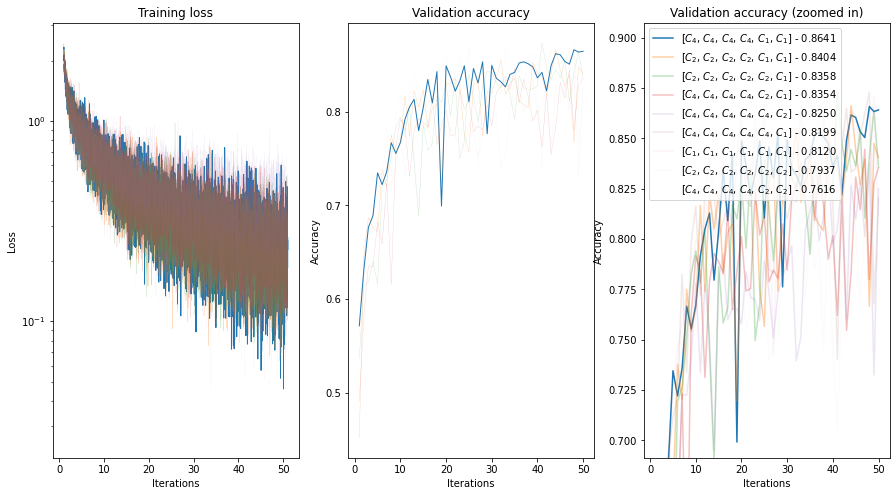

In [29]:
plothillclimb('out/aniti/logshc_2022-06-29_10:53:09.pkl')

0.13625000417232513 0.8920833468437195


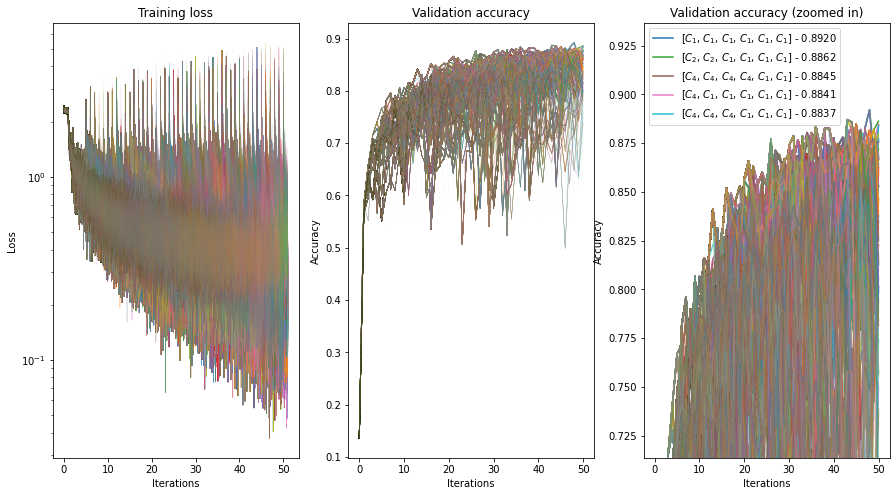

In [23]:
plothillclimb('out/aniti/logshc_2022-06-28_15:57:57.pkl')

0.7133333683013916 0.89041668176651


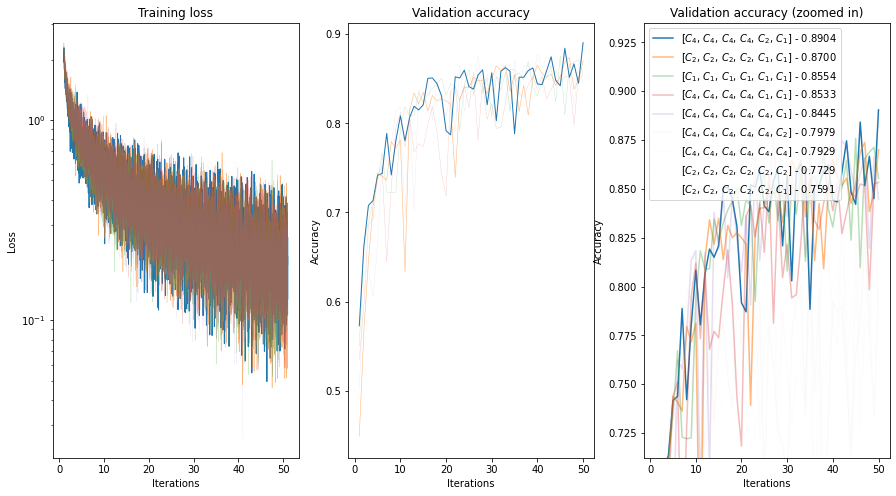

In [31]:
plothillclimb("out/aniti/logsbs_2022-06-29_11:29:15.pkl")

0.3933333456516266 0.8662500381469727


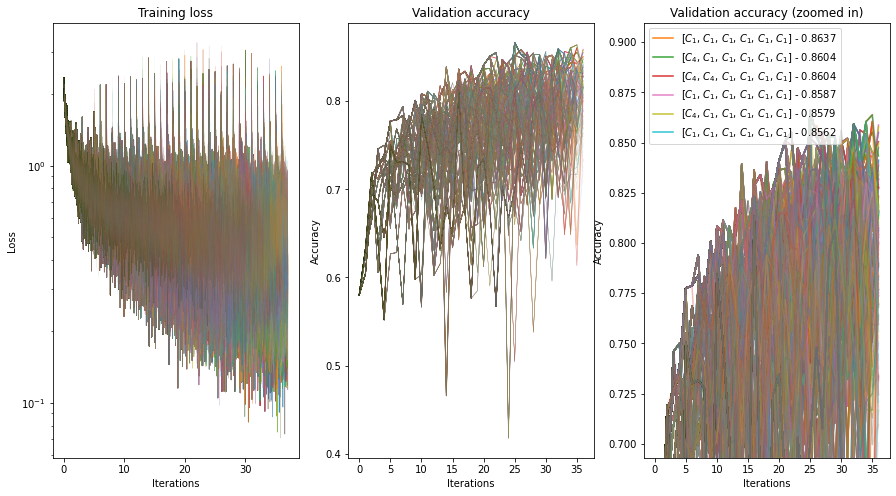

In [38]:
plothillclimb("out/aniti/logshc_2022-06-29_11:46:52.pkl")

0.6787500381469727 0.8641666769981384


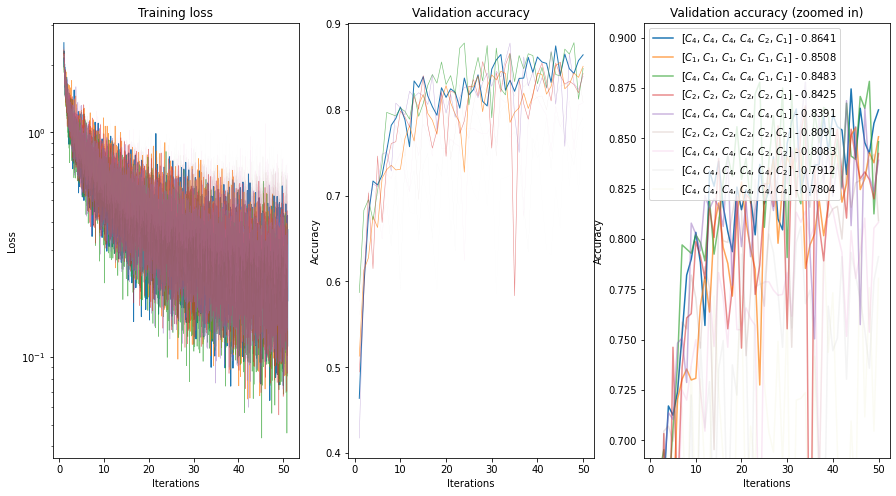

In [49]:
plothillclimb("out/aniti/logsbs_2022-06-30_15:03:04.pkl")

0.33416667580604553 0.8774999976158142


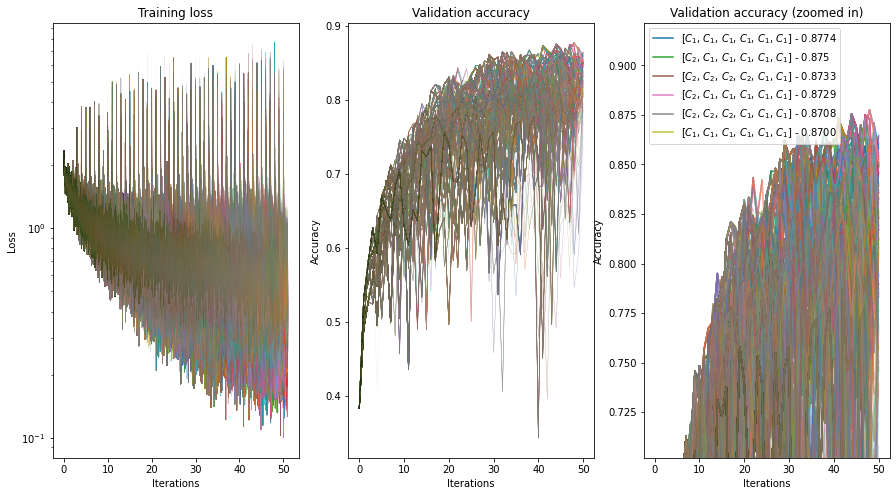

In [51]:
plothillclimb("out/aniti/logshc_2022-06-30_15:04:18.pkl")

0.1133333370089531 0.7033333778381348


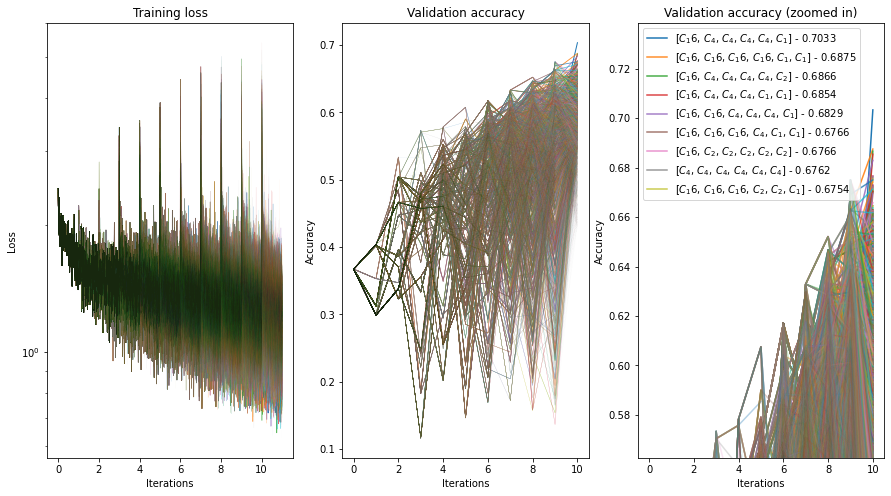

In [57]:
plothillclimb("out/aniti/logshc_2022-06-30_17:33:44.pkl")

0.19166667759418488 0.8179166913032532


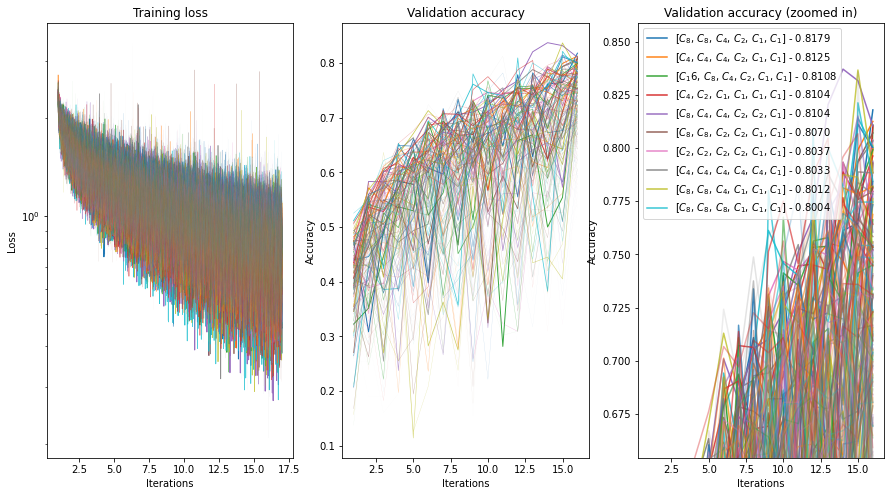

In [58]:
plothillclimb("out/aniti/logsbs_2022-07-01_11:42:08.pkl")